In [2]:
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

/upb/users/m/mengshim/profiles/unix/cs/miniconda3/envs/mengshi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluation Results

After fine-tuning the models, we need to evaluate their performance. We use [GERBIL](https://gerbil-qa.aksw.org/gerbil/config) to calculate the F1 score of each model and language individually. We convert the questions in the test dataset to SPARQL queries, send them to [Wikidata Query Service](https://query.wikidata.org/) to get answers, and build a dataset in QALD format containing the infered SPARQL queries and answers. Then, we upload this file to GERBIL and evaluate it.

We conduct ablation studies using different models with different tokenizers. We fine-tune the models on the [QALD-9-plus](https://github.com/KGQA/QALD_9_plus) training dataset, a multilingual dataset that extends QALD-9 with more questions in nine languages and covers both DBpedia and Wikidata as knowledge graphs, and evaluate them on the test dataset. Since there are only european languages in the QALD-9-plus dataset, we also add Chinese and Japanese translations of questions to expand the coverage of languages for KGQA research and applications and enable multilingual KGQA models to learn from more diverse and rich data. As the QALD-9-Plus dataset incorporated Spanish questions only recently, some of our experiments might have excluded this language from both training and evaluation.

**Note that unless otherwise stated, all answers is limited to 50 results to avoid excessive file size.**

## Experiment 1

The first experiment aims to leverage a multilingual text-to-text transformer model called [mT5-base](https://huggingface.co/google/mt5-base) to answer natural language questions over linked data. 
The model is previously  pre-trained on a large-scale dataset called [LC-QuAD](https://github.com/AskNowQA/LC-QuAD) that contains over 5000 questions and their corresponding SPARQL queries for 16 epochs. 
We also filter out entities and relations in LC-QuAD dataset and add them to mt5 tokenizer to improve tokenizing knowledge graph entities. This new tokenizer is trained on LC-QuAD training dataset. 

We fine-tuned a pre-trained language model on different datasets that contain varying numbers of languages with four settings: one-shot, few-shot, no-en, and all languages. 
- In the one-shot setting, we fine-tuned the model on only English questions. 
- In the few-shot setting, we fine-tuned the model on a small amount of languages. 
- In the no-en setting, we exclude English questions from dataset while including all other languages.
- In the all languages setting, we fine-tuned the model on all the available languages.

The experiment runs for 300 epochs before evaluation.

### mT5 tokenizer + LC-QuAD tokens

First, we show you the results of the mT5 tokenizer on tokenizing SPARQL query. 
Note that these SPARQL queries are preprocessed to simplify tokenization and reduce syntax errors.

We take three example SPARQL queries. 

- Which instruments does Cat Stevens play?

In [62]:
query1 = "SELECT DISTINCT var_uri WHERE bra_open wd_Q154216 wdt_P1303 var_uri sep_dot bra_close"

- Is horse racing a sport?

In [63]:
query2 = "ASK WHERE bra_open wd_Q187916 wdt_P279* wd_Q349 sep_dot bra_close"

- Which states border Illinois?

In [64]:
query3 = "SELECT DISTINCT var_uri WHERE bra_open wd_Q1204 wdt_P47 var_uri sep_dot bra_close"

First, we show how mT5 tokenizer tokenizes SPARQL queries.

In [65]:
mt5_tokenizer = AutoTokenizer.from_pretrained("google/mt5-base")

/upb/users/m/mengshim/profiles/unix/cs/miniconda3/envs/mengshi/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [66]:
tokens = mt5_tokenizer.tokenize(query1)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁bra', '_', 'open', '▁w', 'd', '_', 'Q', '1542', '16', '▁w', 'd', 't', '_', 'P', '1303', '▁var', '_', 'uri', '▁sep', '_', 'dot', '▁bra', '_', 'close'], 

In [67]:
tokens = mt5_tokenizer.tokenize(query2)
print(tokens, end=", ")

['▁', 'ASK', '▁W', 'HERE', '▁bra', '_', 'open', '▁w', 'd', '_', 'Q', '1879', '16', '▁w', 'd', 't', '_', 'P', '279', '*', '▁w', 'd', '_', 'Q', '349', '▁sep', '_', 'dot', '▁bra', '_', 'close'], 

In [68]:
tokens = mt5_tokenizer.tokenize(query3)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁bra', '_', 'open', '▁w', 'd', '_', 'Q', '1204', '▁w', 'd', 't', '_', 'P', '47', '▁var', '_', 'uri', '▁sep', '_', 'dot', '▁bra', '_', 'close'], 

We see that entities and relations are tokenized as some single letters and numbers, therefore, the meaning of entities and relations is lost. 
We filter out entities and relations from LC-QuAD dataset to expand vocabulary of mT5 tokenizer. 

Now, we demonstrate the tokenization results of our new trained tokenizer. 

In [69]:
lcquad_tokenizer = AutoTokenizer.from_pretrained("../lcquad_tokenizer")

In [70]:
tokens = lcquad_tokenizer.tokenize(query1)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁', 'bra_open', '▁', 'wd_Q154', '▁216', '▁', 'wdt_P1303', '▁var', '_', 'uri', '▁', 'sep_dot', '▁', 'bra_close'], 

In [71]:
tokens = lcquad_tokenizer.tokenize(query2)
print(tokens, end=", ")

['▁', 'ASK', '▁W', 'HERE', '▁', 'bra_open', '▁', 'wd_Q18', '▁7', '916', '▁', 'wdt_P279', '▁*', '▁', 'wd_Q349', '▁', 'sep_dot', '▁', 'bra_close'], 

In [72]:
tokens = lcquad_tokenizer.tokenize(query3)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁', 'bra_open', '▁', 'wd_Q1204', '▁', 'wdt_P47', '▁var', '_', 'uri', '▁', 'sep_dot', '▁', 'bra_close'], 

In this case, some entities and relations have been correctly tokenized. 
However, despite the inclusion of many tokens from LC-QuAD into the mT5 tokenizer, it still lacks the complete set of wikidata entities and relations. Consequently, some entities and relations remain incorrectly tokenized. 
The impact of adding entities and relations into a tokenizer on the tokenization quality of SPARQL queries for smaller knowledge graphs is yet to be determined.

### one-shot


We first fine-tune with only English questions, which takes least time for fine-tuning. 

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304030010

In [73]:
exp1_one_shot = pd.read_csv("../pred_files/pretrain_lcqald/1/results.csv")
mask = exp1_one_shot['Language'].str.contains('en')
exp1_one_shot.style.apply(lambda x: ['background: yellow' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.000000,0.000000,0.000000,0.044100,0.044100,0.044100,0.084400
1,be,0.007000,0.332300,0.003600,0.092300,0.095300,0.090700,0.163200
2,de,0.005500,0.140100,0.002800,0.081900,0.082100,0.082200,0.147500
3,en,0.009400,0.221600,0.004800,0.174800,0.178500,0.177700,0.289100
4,fr,0.006700,0.795500,0.003400,0.077600,0.080600,0.076000,0.140900
5,hy,0.003100,0.252600,0.001500,0.041100,0.043800,0.039900,0.076700
6,ja,0.000400,0.021600,0.000200,0.070000,0.070100,0.069900,0.129300
7,lt,0.006600,0.217800,0.003400,0.077600,0.080600,0.076000,0.140200
8,ru,0.003900,0.114800,0.002000,0.079300,0.081700,0.084600,0.151000
9,uk,0.008100,0.207500,0.004100,0.066600,0.074600,0.063900,0.117500


The results of this experiment show that English has the best performance among the languages tested. The other languages, such as `ba` and `hy`, have much lower scores. This suggests that the model is more suited for English than for other languages, and that more data and fine-tuning are needed to improve its performance on other languages.

### four-shot 

We experiment with four languages of questions: en, de, zh, and ru.

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304250003

In [74]:
exp1_four_shot = pd.read_csv("../pred_files/pretrain_lcqald/4/results.csv")
def highlight_language(row):
    if row['Language'] in ['en', 'de', 'zh', 'ru']:
        return ['background-color: yellow']*len(row)
    else:
        return ['']*len(row)
exp1_four_shot.style.apply(highlight_language, axis=1)

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.004000,0.331600,0.002000,0.089700,0.093800,0.088700,0.160700
1,be,0.008600,0.174100,0.004400,0.107200,0.113700,0.105500,0.183900
2,de,0.008800,0.193200,0.004500,0.129900,0.136300,0.128100,0.217300
3,en,0.008900,0.222000,0.004500,0.151800,0.158200,0.150000,0.250200
4,fr,0.006700,0.586600,0.003400,0.077500,0.080400,0.076100,0.141200
5,hy,0.003400,0.335400,0.001700,0.048400,0.051000,0.047200,0.090100
6,ja,0.008800,0.194400,0.004500,0.114600,0.121300,0.112900,0.196100
7,lt,0.009100,0.192900,0.004700,0.097100,0.109700,0.097100,0.172900
8,ru,0.009400,0.210400,0.004800,0.141600,0.146800,0.142500,0.238700
9,uk,0.008600,0.153200,0.004400,0.115000,0.121500,0.113200,0.194400


The experiment also reveals that the languages that are included in the training dataset have better performance than the languages that are not. This indicates that the model can learn from the multilingual data and generalize to similar languages. However, the F1 score of English is lower than the one-shot baseline, which means that the model does not benefit from the additional data for other languages and may suffer from interference from other languages.

### all languages (11)

In all languages setting, we include en, de, zh, ja, ru, fr, hy, ba, be, uk, lt. 
`es` is not included since our Spanish translation of questions is merged later than this experiment.

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304250001

In [75]:
exp1_all = pd.read_csv("../pred_files/pretrain_lcqald/11/results.csv")
exp1_all

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0044,0.2438,0.0022,0.1266,0.1307,0.1256,0.2157
1,be,0.0103,0.2195,0.0053,0.1316,0.1394,0.1293,0.2178
2,de,0.0091,0.2117,0.0047,0.1666,0.1731,0.1648,0.2700
3,en,0.0088,0.1796,0.0045,0.1373,0.1510,0.1355,0.2275
4,fr,0.0067,0.7000,0.0034,0.0775,0.0804,0.0761,0.1412
5,hy,0.0035,0.4320,0.0017,0.0631,0.0657,0.0619,0.1165
6,ja,0.0091,0.2362,0.0047,0.1403,0.1460,0.1402,0.2338
7,lt,0.0102,0.2414,0.0052,0.1260,0.1319,0.1248,0.2145
8,ru,0.0089,0.2319,0.0045,0.1446,0.1582,0.1427,0.2376
9,uk,0.0089,0.1759,0.0046,0.1519,0.1584,0.1501,0.2469


The results show that German has the best performance among all the languages. On the other hand, French and Armenian have the worst performance. The other languages do not show any obvious difference in their performance.

### no-en

We exclude English question to test the influence on English performance. 

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304250002

In [76]:
exp1_no_en = pd.read_csv("../pred_files/pretrain_lcqald/no_en/results.csv")
mask = exp1_one_shot['Language'].str.contains('en')
exp1_one_shot.style.apply(lambda x: ['background: #00ccff' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.000000,0.000000,0.000000,0.044100,0.044100,0.044100,0.084400
1,be,0.007000,0.332300,0.003600,0.092300,0.095300,0.090700,0.163200
2,de,0.005500,0.140100,0.002800,0.081900,0.082100,0.082200,0.147500
3,en,0.009400,0.221600,0.004800,0.174800,0.178500,0.177700,0.289100
4,fr,0.006700,0.795500,0.003400,0.077600,0.080600,0.076000,0.140900
5,hy,0.003100,0.252600,0.001500,0.041100,0.043800,0.039900,0.076700
6,ja,0.000400,0.021600,0.000200,0.070000,0.070100,0.069900,0.129300
7,lt,0.006600,0.217800,0.003400,0.077600,0.080600,0.076000,0.140200
8,ru,0.003900,0.114800,0.002000,0.079300,0.081700,0.084600,0.151000
9,uk,0.008100,0.207500,0.004100,0.066600,0.074600,0.063900,0.117500


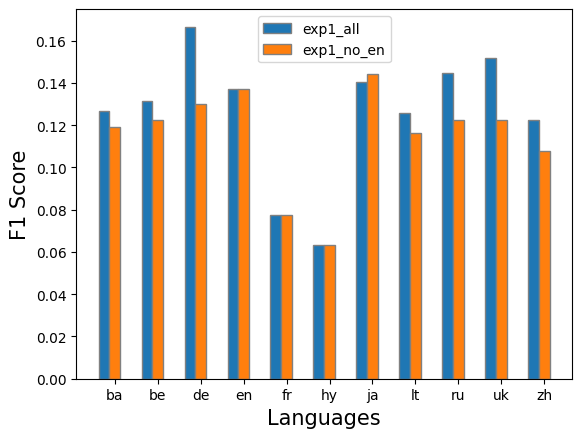

In [77]:

df = exp1_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp1_all"}).merge(
    exp1_no_en[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp1_no_en"}),
    how="outer",
    on="Language"
)

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp1_all"], width=barWidth, edgecolor='grey', label='exp1_all')
plt.bar(br2, df["exp1_no_en"], width=barWidth, edgecolor='grey', label='exp1_no_en')

# Adding Xticks
plt.xlabel('Languages', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))], df["Language"])

plt.legend()
plt.show()

The results show that almost all performance is worse than with English questions, indicating that the cross-lingual transfer is not very effective. The only exception is `ja`, which is improved slightly. However, this improvement is not significant when compared to the performance without English questions, suggesting that the English questions do not provide much benefit for the Japanese language.

Now we compare all settings in Experiment 1

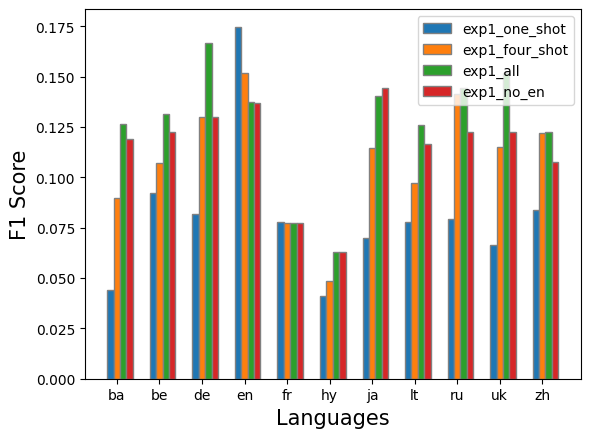

In [78]:
df = exp1_one_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp1_one_shot"}).merge(
    exp1_four_shot[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "exp1_four_shot"}),
    how="outer",
    on="Language"
).merge(
    exp1_all[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "exp1_all"}),
    how="outer",
    on="Language"
).merge(
    exp1_no_en[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "exp1_no_en"}),
    how="outer",
    on="Language"
)

# set width of bar
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, df["exp1_one_shot"], width=barWidth,
        edgecolor='grey', label='exp1_one_shot')
plt.bar(br2, df["exp1_four_shot"], width=barWidth,
        edgecolor='grey', label='exp1_four_shot')
plt.bar(br3, df["exp1_all"], width=barWidth,
        edgecolor='grey', label='exp1_all')
plt.bar(br4, df["exp1_no_en"], width=barWidth,
        edgecolor='grey', label='exp1_no_en')

# Adding Xticks
plt.xlabel('Languages', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
           df["Language"])

plt.legend()
plt.show()


Based on the information presented in the chart, it can be observed that the F1 Score for the English language experiences a consistent decrease, while the F1 scores for other languages demonstrate an upward trend. This finding leads us to suggest that the inclusion of additional languages in the dataset may have an adverse effect on the accuracy of English language inference, while conversely benefiting the accuracy of other languages by providing additional training data. It is noteworthy that the F1 score for French language inference remains relatively stable throughout Experiment 1. Furthermore, it is important to note that a lack of English training data may also negatively impact the accuracy of other languages.

## Experiment 2

In the second experiment, we try google/mt5-base model with mT5 tokenizer **without any pretraining on LC-QuAD dataset** to observe whether pretraining on LC-QuAD and adding tokens to tokenizer improve the performance. 

Furthermore, the experiment is run for 300 epochs prior to evaluation.

### one-shot

First, we try with only English questions.

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304050000

In [4]:
exp2_one_shot = pd.read_csv("../pred_files/mt5/1_mt5/results.csv")
mask = exp2_one_shot['Language'].str.contains('en')
exp2_one_shot.style.apply(lambda x: ['background: yellow' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.000100,0.003900,0.000000,0.051500,0.051500,0.051500,0.097100
1,be,0.004600,0.129900,0.002300,0.086000,0.093400,0.085400,0.152400
2,de,0.008800,0.151900,0.004600,0.115200,0.128900,0.111200,0.189000
3,en,0.009800,0.219300,0.005000,0.218500,0.232400,0.214300,0.320700
4,fr,0.006400,0.606100,0.003200,0.065000,0.073200,0.062500,0.117500
5,hy,0.003100,0.872700,0.001500,0.048500,0.051200,0.047300,0.090200
6,ja,0.003200,0.074100,0.001600,0.055400,0.065700,0.052100,0.096300
7,lt,0.006300,0.147700,0.003200,0.050300,0.058500,0.048000,0.090300
8,ru,0.004900,0.093600,0.002500,0.100700,0.108600,0.100100,0.172400
9,uk,0.004600,0.094100,0.002300,0.056700,0.064500,0.062100,0.113900


In Experiment 2, the F1 Score for English is higher than that of the one-shot setting in Experiment 1, indicating an improved performance for this language. However, the performance for all other languages, except for German and Russian, is found to be inferior to Experiment 1. 

### four-shot

We also choose `en`, `de`, `zh`, and `ru` for four-shot training.

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304040000

In [80]:
exp2_four_shot = pd.read_csv("../pred_files/mt5/4_mt5/results.csv")
exp2_four_shot.style.apply(highlight_language, axis=1)

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.004500,0.202300,0.002300,0.126700,0.134200,0.125600,0.211600
1,be,0.009600,0.183500,0.004900,0.148900,0.159300,0.151400,0.227000
2,de,0.009800,0.170800,0.005100,0.206200,0.217700,0.203300,0.282100
3,en,0.009600,0.134000,0.005000,0.191500,0.203000,0.188600,0.259600
4,fr,0.006800,0.540800,0.003400,0.077500,0.080400,0.076100,0.140900
5,hy,0.003700,0.311800,0.001900,0.057900,0.059700,0.059500,0.111900
6,ja,0.008200,0.190400,0.004200,0.143000,0.152600,0.139600,0.214400
7,lt,0.008800,0.195600,0.004500,0.134000,0.142800,0.131100,0.211000
8,ru,0.009500,0.131300,0.004900,0.154800,0.166400,0.151800,0.223600
9,uk,0.009400,0.142100,0.004800,0.166400,0.176600,0.166100,0.239100


It has been found that the F1 score decreases slightly for `en`. However, it improves significantly for other languages that are already present in the training dataset. Interestingly, the F1 score also tends to increase significantly for languages like `ja`, which have linguistic connections to `zh`, and `ba`, `be`, and `uk`, which have linguistic connections to `ru` . These findings suggest that training models with linguistically related languages may enhance the overall performance of the model.

### all languages (11)

We also fine-tuned for all 11 languages. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304080000

In [81]:
exp2_all = pd.read_csv("../pred_files/mt5/11_mt5/results.csv")
exp2_all

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0056,0.1589,0.0029,0.1571,0.1628,0.1557,0.2457
1,be,0.0098,0.1442,0.0051,0.1986,0.2171,0.1956,0.2704
2,de,0.0099,0.1477,0.0051,0.1962,0.2137,0.1920,0.2634
3,en,0.0099,0.1439,0.0051,0.1914,0.2134,0.1884,0.2585
4,es,0.0100,0.1481,0.0052,0.2059,0.2137,0.2035,0.2787
5,fr,0.0068,0.5354,0.0034,0.0775,0.0804,0.0761,0.1408
6,hy,0.0034,0.1957,0.0017,0.0558,0.0584,0.0546,0.1030
7,ja,0.0104,0.1583,0.0054,0.1966,0.2052,0.1945,0.2625
8,lt,0.0104,0.1307,0.0054,0.1900,0.2089,0.1854,0.2641
9,ru,0.0104,0.1369,0.0054,0.1775,0.1907,0.1742,0.2393


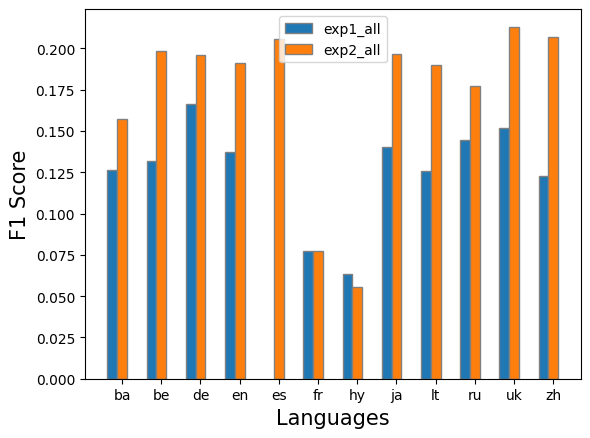

In [82]:
df = exp2_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2"}).merge(
    exp1_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp1"}),
    how="outer",
    on="Language"
)

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp1"], width=barWidth,
        edgecolor='grey', label='exp1_all')
plt.bar(br2, df["exp2"], width=barWidth,
        edgecolor='grey', label='exp2_all')

# Adding Xticks
plt.xlabel('Languages', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
           df["Language"])

plt.legend()
plt.show()


The F1 scores for all languages except `hy` are higher than all languages setting in Experiment 1. For `zh`, the F1 Score is increased by 8.43.

To know how the F1 Score decreases with limitation of 50 results, we generate a qald file **without limitation**. Fortunatly, these files are not very large. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304080001

In [83]:
exp2_all_wo_limit = pd.read_csv("../pred_files/mt5/11_mt5_all/results.csv")
exp2_all_wo_limit

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0047,0.0116,0.0030,0.1573,0.1625,0.1563,0.2457
1,be,0.0071,0.0064,0.0080,0.2164,0.2316,0.2151,0.2852
2,de,0.0079,0.0077,0.0080,0.2139,0.2280,0.2115,0.2828
3,en,0.0072,0.0066,0.0081,0.2093,0.2280,0.2083,0.2749
4,es,0.0066,0.0055,0.0082,0.2237,0.2283,0.2234,0.2950
5,fr,0.0111,0.4137,0.0056,0.0880,0.0877,0.0882,0.1613
6,hy,0.0060,0.0144,0.0038,0.0660,0.0659,0.0662,0.1235
7,ja,0.0069,0.0059,0.0083,0.2144,0.2198,0.2140,0.2761
8,lt,0.0076,0.0071,0.0083,0.1931,0.2087,0.1902,0.2650
9,ru,0.0070,0.0060,0.0083,0.1953,0.2051,0.1938,0.2553


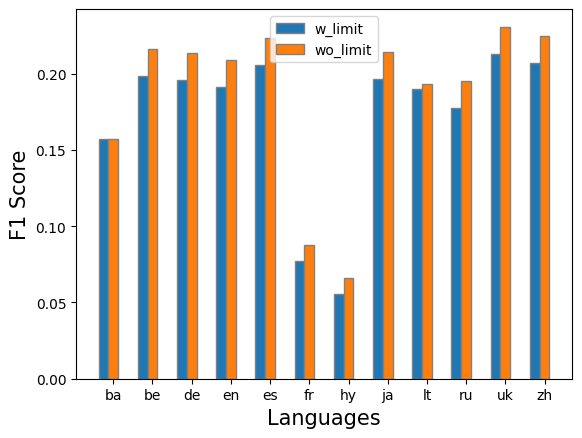

In [84]:
exp2 = exp2_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2"})
exp2_wo = exp2_all_wo_limit[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2_wo_limit"})
df = exp2.merge(exp2_wo, how="outer", on="Language")

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp2"], width = barWidth,
		edgecolor ='grey', label ='w_limit')
plt.bar(br2, df["exp2_wo_limit"], width = barWidth,
		edgecolor ='grey', label ='wo_limit')

# Adding Xticks
plt.xlabel('Languages', fontsize = 15)
plt.ylabel('F1 Score', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
		df["Language"])

plt.legend()
plt.show()

The macro F1 Score is improved about 0 to 2 depending on language without limitation.

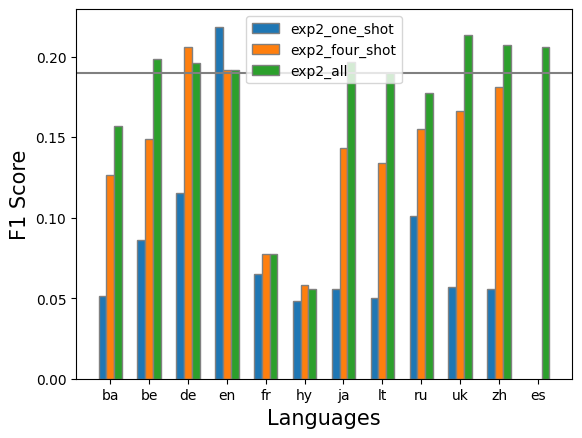

In [85]:
df = exp2_one_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2_one_shot"}).merge(
    exp2_four_shot[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "exp2_four_shot"}),
    how="outer",
    on="Language"
).merge(
    exp2_all[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "exp2_all"}),
    how="outer",
    on="Language"
)

# set width of bar
barWidth = 0.2

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, df["exp2_one_shot"], width=barWidth,
        edgecolor='grey', label='exp2_one_shot')
plt.bar(br2, df["exp2_four_shot"], width=barWidth,
        edgecolor='grey', label='exp2_four_shot')
plt.bar(br3, df["exp2_all"], width=barWidth,
        edgecolor='grey', label='exp2_all')
plt.axhline(0.19, color="gray")

# Adding Xticks
plt.xlabel('Languages', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
           df["Language"])

plt.legend()
plt.show()

In Experiment 2 all languages setting, we observed a significant improvement in the performance of our model for all languages. Nine of the twelve languages reached a F1 score above 0.19. However, French and Hungarian still performed worst among the languages, suggesting that they might require more data or a different approach. The results of Experiment 2 clearly surpassed those of Experiment 1, demonstrating the effectiveness of this method.

The results of Experiment 1 and 2 indicate that the one-shot setting achieves the highest F1 Score for `en`. This suggests that multilingual fine-tuning has a negative impact on the performance of a single language. However, in a multilingual KGQA system, the performance of other languages is also relevant. As the number of languages in the training dataset increases, so does the average F1 Score.

## Experiment 3

In this experiment, we want to figure out whether the mT5 tokenizer with LC-QuAD tokens really improves the performance. Hence, we use the mT5-base model without pretraining on LC-QuAD from Experiment 2 and tokenizer from Experiment 1. 

The experiment is run for 300 epochs prior to evaluation.

### one-shot

We first try with the one-shot setting, fine-tune with only English questions. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304050004

In [86]:
exp3_one_shot = pd.read_csv("../pred_files/mt5_lcquad_tokenizer/1_mt5_lcquadtokenizer/results.csv")
mask = exp3_one_shot['Language'].str.contains('en')
exp3_one_shot.style.apply(lambda x: ['background: yellow' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.003200,0.193200,0.001600,0.058500,0.058800,0.058100,0.108900
1,be,0.008600,0.185400,0.004400,0.110700,0.121300,0.109100,0.189200
2,de,0.008200,0.181300,0.004200,0.100500,0.107200,0.098600,0.171000
3,en,0.009100,0.241600,0.004600,0.166600,0.172600,0.166200,0.271800
4,fr,0.006700,0.360800,0.003400,0.077600,0.080600,0.076000,0.140700
5,hy,0.000000,0.000000,0.000000,0.036800,0.036800,0.036800,0.070700
6,ja,0.003800,0.169000,0.001900,0.088600,0.095600,0.087900,0.156900
7,lt,0.007100,0.172800,0.003600,0.079300,0.086100,0.077100,0.140600
8,ru,0.007700,0.211100,0.003900,0.112200,0.123600,0.108800,0.188200
9,uk,0.008500,0.164800,0.004400,0.103400,0.121600,0.100300,0.174900


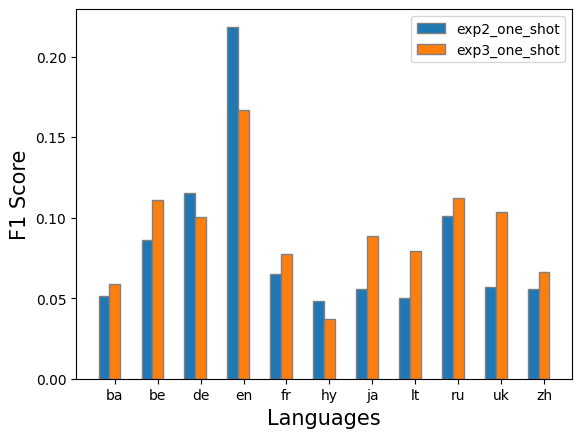

In [87]:
exp2 = exp2_one_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2"})
exp3 = exp3_one_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp3"})
df = exp2.merge(exp3, how="outer", on="Language")

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp2"], width = barWidth,
		edgecolor ='grey', label ='exp2_one_shot')
plt.bar(br2, df["exp3"], width = barWidth,
		edgecolor ='grey', label ='exp3_one_shot')

# Adding Xticks
plt.xlabel('Languages', fontsize = 15)
plt.ylabel('F1 Score', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
		df["Language"])

plt.legend()
plt.show()

The results show that only `de`, `en`, and `hy` have a lower F1 score than in Experiment 2 one-shot setting. 

### four-shot

Then, we try a four-shot setting, fine-tune with questions in `en`, `de`, `zh`, `ru`

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304050001

In [88]:
exp3_four_shot = pd.read_csv("../pred_files/mt5_lcquad_tokenizer/4_mt5_lcquadtokenizer/results.csv")
exp3_four_shot.style.apply(highlight_language, axis=1)

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.003900,0.202000,0.002000,0.089700,0.093800,0.088700,0.159100
1,be,0.008300,0.142100,0.004300,0.107100,0.113500,0.105400,0.181900
2,de,0.008900,0.173600,0.004600,0.151300,0.157800,0.149600,0.240600
3,en,0.008900,0.172500,0.004600,0.159100,0.165300,0.164200,0.257800
4,fr,0.006700,0.795500,0.003400,0.077500,0.080400,0.076100,0.141100
5,hy,0.003400,0.530000,0.001700,0.055800,0.058400,0.054600,0.103400
6,ja,0.008600,0.203600,0.004400,0.121800,0.128100,0.120100,0.204100
7,lt,0.008600,0.156800,0.004400,0.092500,0.099200,0.090800,0.159500
8,ru,0.008700,0.209400,0.004400,0.122000,0.135600,0.120200,0.202900
9,uk,0.008700,0.189300,0.004400,0.129100,0.135600,0.127400,0.213500


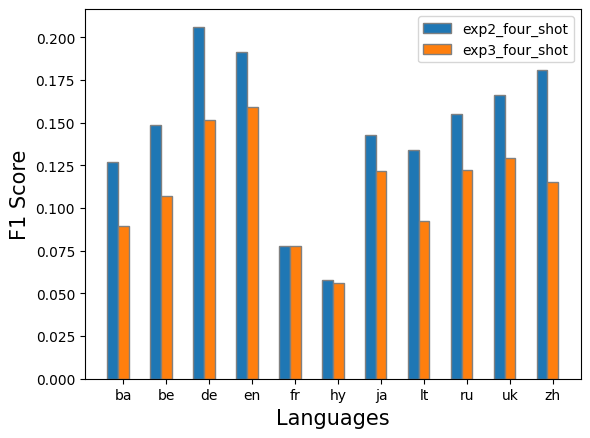

In [89]:
exp2 = exp2_four_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2"})
exp3 = exp3_four_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp3"})
df = exp2.merge(exp3, how="outer", on="Language")

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp2"], width = barWidth,
		edgecolor ='grey', label ='exp2_four_shot')
plt.bar(br2, df["exp3"], width = barWidth,
		edgecolor ='grey', label ='exp3_four_shot')

# Adding Xticks
plt.xlabel('Languages', fontsize = 15)
plt.ylabel('F1 Score', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
		df["Language"])

plt.legend()
plt.show()

As the number of languages in the training set increases, the F1 score for all languages in Experiment 2 four-shot setting is higher than in Experiment 3. This suggests that the language model leverages tokens in the tokenizer when the training dataset is small. However, when the training dataset is large, the language model learns the entity and relation information by itself and the performance is better than using a pre-trained tokenizer. Furthermore, the added tokens are not trained enough only on LC-QuAD dataset. 

## Experiment 4

In this experiment, We use mT5-base and the mT5 tokenizer as in the Experiment 2, since this configuration achieves the best performance. The input data consisted of natural language questions with part-of-speech tags, dependency relations, and dependency levels as additional features. The idea of using these features was inspired by [SGPT](https://arxiv.org/abs/2202.08904). We train the model for 300 epochs as in previous experiments. 

In this experiment, we enhance the question string with **additional linguistic features**, such as *part-of-speech tags, dependency relations, and dependency levels*, to facilitate the language model's comprehension of the question.

Here, we give some examples of question with linguistic context:

In [90]:
pd.set_option('max_colwidth', 1000)
pd.read_csv("../datasets/11_linguistic/q9pp_train.csv").question.head(3)

0               List all boardgames by GMT . <pad> VERB DET NOUN ADP PROPN PUNCT <pad> ROOT det dobj prep pobj punct <pad> 1 3 2 3 4 2
1     Liste die Brettspiele von GMT auf . <pad> NOUN DET NOUN ADP PROPN ADP PUNCT <pad> ROOT nk oa pg nk svp punct <pad> 1 3 2 3 4 2 2
2    Zeige mir alle Brettspiele von GMT . <pad> VERB PRON DET NOUN ADP PROPN PUNCT <pad> ROOT da nk oa pg nk punct <pad> 1 2 3 2 3 4 2
Name: question, dtype: object

### all languages (11)

We include `en`, `de`, `zh`, `ja`, `ru`, `fr`, `ba`, `be`, `uk`, `lt`, and `es`. 
There is no spacy model for Armenian, therefore Armenian is excluded in this experiment. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304170000

In [4]:
exp4_all = pd.read_csv("../pred_files/mt5_linguistic/11_linguistic_mt5/results.csv")
exp4_all

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0066,0.1858,0.0034,0.1590,0.1682,0.1571,0.2498
1,be,0.0101,0.1567,0.0052,0.2133,0.2245,0.2114,0.2851
2,de,0.0101,0.1397,0.0053,0.2253,0.2392,0.2212,0.2939
3,en,0.0103,0.1515,0.0053,0.2432,0.2543,0.2433,0.3200
4,es,0.0100,0.1450,0.0052,0.2353,0.2467,0.2335,0.3161
5,fr,0.0067,0.4380,0.0034,0.0849,0.0878,0.0835,0.1531
6,ja,0.0099,0.1660,0.0051,0.2008,0.2098,0.2047,0.2832
7,lt,0.0095,0.1350,0.0049,0.2179,0.2312,0.2138,0.2988
8,ru,0.0099,0.1348,0.0052,0.2130,0.2243,0.2102,0.2775
9,uk,0.0101,0.1349,0.0052,0.2424,0.2537,0.2396,0.3019


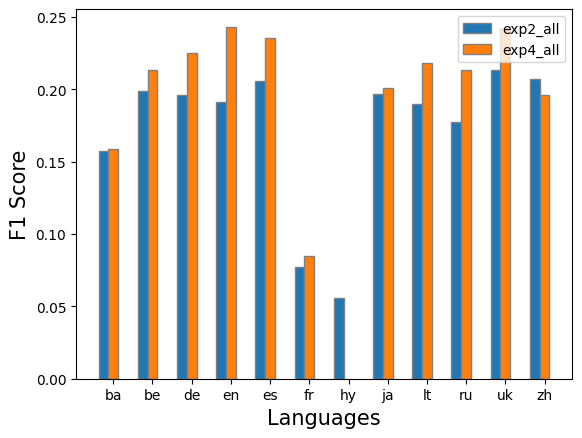

In [92]:
exp2 = exp2_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2"})
exp4 = exp4_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp4"})
df = exp2.merge(exp4,how="outer", on="Language")

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp2"], width = barWidth,
		edgecolor ='grey', label ='exp2_all')
plt.bar(br2, df["exp4"], width = barWidth,
		edgecolor ='grey', label ='exp4_all')

# Adding Xticks
plt.xlabel('Languages', fontsize = 15)
plt.ylabel('F1 Score', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
		df["Language"])

plt.legend()
plt.show()


According to our findings, a significant improvement can be observed in the F1 score of most languages. In the case of other languages, their F1 scores are still comparable to the outcomes observed in Experiment 2. Remarkably, English achieved a noteworthy increase in its F1 score by 5.18, indicating a substantial improvement.

## Comparison to other works

According to KGQA leaderboard, there are some multilingual KGQA systems. We compare our best results by now to them. Also, we take our all-language setting as the baseline for our experiments.

In [93]:
qanswer = pd.read_csv("../previous_paper_results/QAnswer.csv")
platypus = pd.read_csv("../previous_paper_results/Platypus.csv")
deeppavlov = pd.read_csv("../previous_paper_results/DeepPavlov.csv")

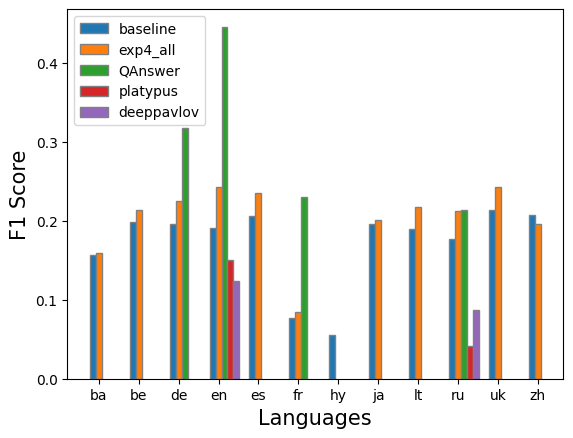

In [100]:
df = exp2_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2"}).merge(
    exp4_all[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "exp4"}),
    how="outer",
    on="Language"
).merge(
    qanswer[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "qanswer"}),
    how="outer",
    on="Language"
).merge(
    platypus[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "platypus"}),
    how="outer",
    on="Language"
).merge(
    deeppavlov[["Language", "Macro F1"]].rename(
        columns={"Macro F1": "deeppavlov"}),
    how="outer",
    on="Language"
)

# set width of bar
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

# # Make the plot
plt.bar(br1, df["exp2"], width=barWidth,
        edgecolor='grey', label='baseline')
plt.bar(br2, df["exp4"], width=barWidth,
        edgecolor='grey', label='exp4_all')
plt.bar(br3, df["qanswer"], width=barWidth,
        edgecolor='grey', label='QAnswer')
plt.bar(br4, df["platypus"], width=barWidth,
        edgecolor='grey', label='platypus')
plt.bar(br5, df["deeppavlov"], width=barWidth,
        edgecolor='grey', label='deeppavlov')


# Adding Xticks
plt.xlabel('Languages', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
           df["Language"])

plt.legend()
plt.show()


Currently, the [KGQA leaderboard](https://kgqa.github.io/leaderboard/dbpedia/qald.html#qald-9-plus) indicates that [QAnswer](https://link.springer.com/chapter/10.1007/978-3-030-49461-2_25) outperforms other systems. QAnswer is capable of supporting multiple languages, namely en, de, fr, it, es, pt, nl, zh, ar, ja, and ru. It is noteworthy that we have not obtained the test data for the languages, namely it, es, pt, nl, and ar, which prevents us from evaluating the performance of QAnswer on these languages. Additionally, the zh, ja, and es translation of questions were not available when QAnswer was assessed on the QALD-9-Plus dataset, hence the evaluation results are limited to en, de, ru, and fr. 

Based on the available results, it is evident that QAnswer has demonstrated superior performance in all available languages, while our approach only appears to be competitive in ru.

## Experiment 5

fine-tune mT5-xl(3.7B)

### one-shot

https://gerbil-qa.aksw.org/gerbil/experiment?id=202305110000

In [3]:
exp5_one_shot = pd.read_csv("../pred_files/1_mt5-xl/results.csv")
exp5_one_shot

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0003,0.0352,0.0002,0.0735,0.0735,0.0735,0.1351
1,be,0.0210,0.0116,0.1117,0.1027,0.1052,0.1162,0.2000
2,de,0.0125,0.2957,0.0064,0.1644,0.1736,0.1633,0.2640
3,en,0.0131,0.0367,0.0080,0.2263,0.2304,0.2342,0.3453
4,es,0.0000,0.0000,0.0000,0.0441,0.0441,0.0441,0.0845
5,fr,0.0062,0.0071,0.0055,0.0881,0.0885,0.0952,0.1732
6,hy,0.0060,0.0147,0.0038,0.0587,0.0586,0.0588,0.1107
7,ja,0.0045,0.0047,0.0043,0.0857,0.0960,0.0906,0.1573
8,lt,0.0056,0.0052,0.0061,0.1132,0.1198,0.1131,0.1939
9,ru,0.0072,0.0180,0.0045,0.1252,0.1315,0.1314,0.2216


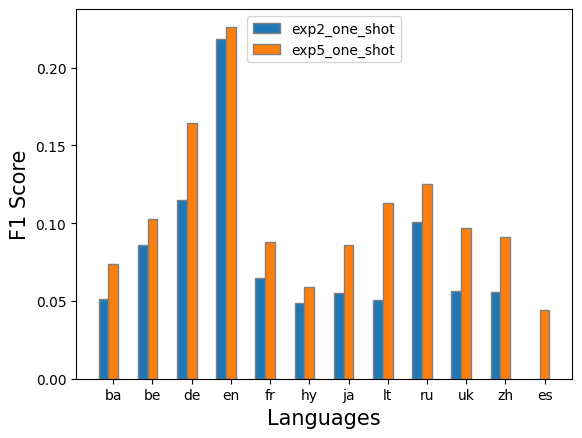

In [5]:
df = exp2_one_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp2_one_shot"}).merge(
    exp5_one_shot[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp5_one_shot"}),
    how="outer",
    on="Language"
)

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp2_one_shot"], width=barWidth,
        edgecolor='grey', label='exp2_one_shot')
plt.bar(br2, df["exp5_one_shot"], width=barWidth,
        edgecolor='grey', label='exp5_one_shot')

# Adding Xticks
plt.xlabel('Languages', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
           df["Language"])

plt.legend()
plt.show()

### all languages with linguistic context

https://gerbil-qa.aksw.org/gerbil/experiment?id=202305120161

In [3]:
exp5_all_ling = pd.read_csv("../pred_files/11_linguistic_mt5-xl/results.csv")
exp5_all_ling

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0044,0.0125,0.0027,0.1149,0.1179,0.1236,0.2029
1,be,0.0103,0.0105,0.0102,0.1951,0.2120,0.1938,0.2814
2,de,0.0310,0.0374,0.0265,0.2153,0.2213,0.2201,0.3001
3,en,0.0281,0.0301,0.0263,0.2016,0.2079,0.2003,0.2851
4,es,0.0000,0.0000,0.0000,0.0441,0.0441,0.0441,0.0845
5,fr,0.0111,0.4070,0.0056,0.0880,0.0877,0.0882,0.1611
6,ja,0.0362,0.0573,0.0265,0.2121,0.2226,0.2113,0.2877
7,lt,0.0097,0.0098,0.0097,0.2139,0.2203,0.2204,0.2986
8,ru,0.0093,0.0093,0.0094,0.2059,0.2194,0.2044,0.2861
9,uk,0.0251,0.0221,0.0291,0.1744,0.1913,0.1722,0.2489


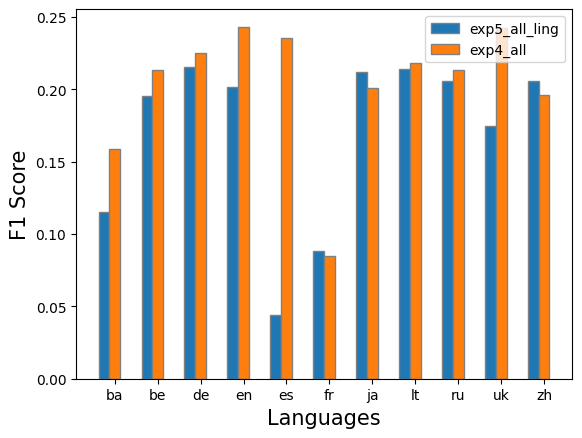

In [5]:
df = exp5_all_ling[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp5_all_ling"}).merge(
    exp4_all[["Language", "Macro F1"]].rename(columns={"Macro F1": "exp4_all"}),
    how="outer",
    on="Language"
)

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(df["Language"]))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, df["exp5_all_ling"], width=barWidth,
        edgecolor='grey', label='exp5_all_ling')
plt.bar(br2, df["exp4_all"], width=barWidth,
        edgecolor='grey', label='exp4_all')

# Adding Xticks
plt.xlabel('Languages', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
plt.xticks([r + barWidth for r in range(len(df["Language"]))],
           df["Language"])

plt.legend()
plt.show()

In [3]:

exp6_all_ling = pd.read_csv("../pred_files/qald9-plus-all/result.csv")
exp6_all_ling

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0005,0.0003,0.0070,0.1350,0.1441,0.1457,0.2417
1,be,0.0009,0.0005,0.0125,0.2364,0.2385,0.2406,0.3523
2,de,0.0028,0.0015,0.0158,0.2540,0.2555,0.2625,0.3744
3,en,0.0104,0.0079,0.0155,0.2751,0.2766,0.2842,0.4072
4,es,0.0000,0.0000,0.0000,0.0441,0.0441,0.0441,0.0845
5,fr,0.0108,0.4198,0.0055,0.0953,0.0951,0.0956,0.1738
6,ja,0.0008,0.0004,0.0121,0.2339,0.2337,0.2491,0.3559
7,lt,0.0023,0.0012,0.0235,0.2250,0.2247,0.2299,0.3482
8,ru,0.0006,0.0003,0.0086,0.2240,0.2253,0.2332,0.3415
9,uk,0.0006,0.0003,0.0078,0.2434,0.2492,0.2461,0.3629
